# EuroCity Persons Faster-RCNN Detection

# Initialisation
Some installs and getting the dataset

Import the dataset.

In [0]:
import json
import zipfile
from google.colab import drive

# get zip files containing the dataset (images and labels)
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip '/content/drive/My Drive/Colab Notebooks/DLAV/train_set/amsterdam_train_labels.zip' -d '/tmp/train_labels' # 1077 images
!unzip '/content/drive/My Drive/Colab Notebooks/DLAV/train_set/amsterdam_train_imgs.zip' -d '/tmp/train_imgs'
!unzip '/content/drive/My Drive/Colab Notebooks/DLAV/validation_set/amsterdam_valid_labels.zip' -d '/tmp/valid_labels' # 179 (tot 1256) images
!unzip '/content/drive/My Drive/Colab Notebooks/DLAV/validation_set/amsterdam_valid_imgs.zip' -d '/tmp/valid_imgs'

!unzip '/content/drive/My Drive/Colab Notebooks/DLAV/train_set/barcelona_train_labels.zip' -d '/tmp/train_labels' # 1260 images
!unzip '/content/drive/My Drive/Colab Notebooks/DLAV/train_set/barcelona_train_imgs.zip' -d '/tmp/train_imgs'
!unzip '/content/drive/My Drive/Colab Notebooks/DLAV/validation_set/barcelona_valid_labels.zip' -d '/tmp/valid_labels'  # 262 (tot 1522) images
!unzip '/content/drive/My Drive/Colab Notebooks/DLAV/validation_set/barcelona_valid_imgs.zip' -d '/tmp/valid_imgs'

!unzip '/content/drive/My Drive/Colab Notebooks/DLAV/train_set/basel_train_labels.zip' -d '/tmp/train_labels' # 629 images
!unzip '/content/drive/My Drive/Colab Notebooks/DLAV/train_set/basel_train_imgs.zip' -d '/tmp/train_imgs'
!unzip '/content/drive/My Drive/Colab Notebooks/DLAV/validation_set/basel_valid_labels.zip' -d '/tmp/valid_labels' # 102 (tot 731) images
!unzip '/content/drive/My Drive/Colab Notebooks/DLAV/validation_set/basel_valid_imgs.zip' -d '/tmp/valid_imgs'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /tmp/train_imgs/amsterdam_00957.png  
  inflating: /tmp/train_imgs/amsterdam_00958.png  
  inflating: /tmp/train_imgs/amsterdam_00959.png  
  inflating: /tmp/train_imgs/amsterdam_00960.png  
  inflating: /tmp/train_imgs/amsterdam_00961.png  
  inflating: /tmp/train_imgs/amsterdam_00962.png  
  inflating: /tmp/train_imgs/amsterdam_00963.png  
  inflating: /tmp/train_imgs/amsterdam_00964.png  
  inflating: /tmp/train_imgs/amsterdam_00965.png  
  inflating: /tmp/train_imgs/amsterdam_00966.png  
  inflating: /tmp/train_imgs/amsterdam_00967.png  
  inflating: /tmp/train_imgs/amsterdam_00968.png  
  inflating: /tmp/train_imgs/amsterdam_00969.png  
  inflating: /tmp/train_imgs/amsterdam_00970.png  
  inflating: /tmp/train_imgs/amsterdam_00971.png  
  inflating: /tmp/train_imgs/amsterdam_00972.png  
  inflating: /tmp/train_imgs/amsterdam_00973.png  
  inflating: /tmp/train_imgs/amsterdam_00974.png  
  in

In [0]:
%%shell
pip install cython
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-9lon9l02
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-9lon9l02
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=275258 sha256=86010637a6ac1e6ef68155fa7c08d72ea1084de6d077a80e95100c4d1aba1d8e
  Stored in directory: /tmp/pip-ephem-wheel-cache-puf8y2ic/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.0
    Uninstalling pycocotools-2.0.0:
      Successfully uninstalled pycocotools-2.0.0


#Dataloader
Define a `torch.utils.data.Dataset` class for the ECP dataset.

In [0]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

class ECPdataset(torch.utils.data.Dataset):
    def __init__(self, root, purp, transforms=None):
        self.root = root
        self.purp = purp
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, str(purp) + "_imgs"))))
        self.labels = list(sorted(os.listdir(os.path.join(root, str(purp) + "_labels"))))

    def __getitem__(self, idx):
        # load images and data 
        root_img = self.root + "/" + str(self.purp) + "_imgs"
        img_path = os.path.join(root_img, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        root_data = self.root + "/" + str(self.purp) + "_labels"
        data_path = os.path.join(root_data, self.labels[idx])
        with open(data_path) as json_file:
          data = json.load(json_file)

        # get boxes and identities
        boxes = []
        identities = []

        for i in range(len(data['children'])):
          identity = data['children'][i]['identity']
          if identity == 'pedestrian' or identity == 'rider':
            box = [data['children'][i]['x0'], data['children'][i]['y0'], \
                   data['children'][i]['x1'], data['children'][i]['y1']]
            boxes.append(box)
            if identity == 'pedestrian':
              identities.append(1)
            else:
              identities.append(2)

          for j in range(len(data['children'][i]['children'])):
            identity = data['children'][i]['children'][j]['identity']
            if identity == 'pedestrian' or identity == 'rider':
              box = [data['children'][i]['children'][j]['x0'], data['children'][i]['children'][j]['y0'], \
                     data['children'][i]['children'][j]['x1'], data['children'][i]['children'][j]['y1']]
              boxes.append(box)
              if identity == 'pedestrian':
                identities.append(1)
              else:
                identities.append(2)

        # to avoid error if no pedestrians or riders on image
        if len(boxes) == 0:
          boxes = [[0,0,1,1]]
          identities = [0]

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        identities = torch.as_tensor(identities, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = identities
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

#Model
Define the model.

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

#Functions for training and evaluation

Get helper functions to simplify training and evaluating detection models. engine.py is modified and load from drive further below.

In [0]:
%%shell

# download TorchVision repo to use some files from references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
#cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 7994 (delta 0), reused 1 (delta 0), pack-reused 7993
Receiving objects: 100% (7994/7994), 10.12 MiB | 6.66 MiB/s, done.
Resolving deltas: 100% (5477/5477), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


Define helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection`.

In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/DLAV/')
# import engine

# Necessary to force update of engine.py
import importlib
#importlib.reload(engine)

# from engine import train_one_epoch, evaluate
import utils
import transforms as T

import math
import sys
import time
import torch

import torchvision.models.detection.mask_rcnn

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
    return losses
    
def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for image, targets in metric_logger.log_every(data_loader, 100, header):
        image = list(img.to(device) for img in image)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(image)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)

    # get the AP metric of interest
    for iou_type, coco_eval in coco_evaluator.coco_eval.items():
        metrics = coco_eval.stats

    return metrics

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    #if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
    #    transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#Instantiation 
Instantiate dataset class and data transforms.

In [0]:
# use dataset and defined transformations
dataset_train = ECPdataset('/tmp','train', get_transform(train=True))
dataset_valid = ECPdataset('/tmp','valid', get_transform(train=False))

#dataset = ECPdataset('/content/drive/My Drive/Colab Notebooks/DLAV/Miniset', get_transform(train=True))
#dataset_test = ECPdataset('/content/drive/My Drive/Colab Notebooks/DLAV/Miniset', get_transform(train=False))

# split the dataset in train and test set
#torch.manual_seed(1)
#indices = torch.randperm(len(dataset)).tolist()
#dataset_train = torch.utils.data.Subset(dataset, indices[0:-300])
#dataset_valid = torch.utils.data.Subset(dataset, indices[-300:])

# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid, batch_size=4, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Instantiate the model and the optimizer.

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Three classes - background, pedestrian, rider
num_classes = 3

# Get the model using helper function
model = get_instance_segmentation_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001,
                            momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler which decreases the learning rate by
# 3x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.3)

# Loading saved model to resume training.

In [0]:
import torch
checkpoint = torch.load('/content/drive/My Drive/Colab Notebooks/DLAV/Saves/resnet50_fullytrained_8bst_lr0dot001_ss5_gamma0dot3')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epochs']
history = checkpoint['history']
model.epochs = epoch

model.train()

# Train
Train the model with evaluation at the end of every epoch. Inspired from https://github.com/WillKoehrsen/pytorch_challenge/blob/master/Transfer%20Learning%20in%20PyTorch.ipynb

In [0]:
num_epochs = 50

# Early stopping intialization
epochs_no_improve = 0
max_epochs_stop = 10

# Number of epochs already trained (if using loaded in model weights)
try:
    valid_AP_max = checkpoint['valid_AP_max']
    print(f'Model has been trained for: {model.epochs} epochs, with {valid_AP_max:.4f} validation AP.')
except:
    model.epochs = 0
    valid_AP_max = 0
    history = []
    print(f'Ready to start training from scratch.')

In [0]:
for epoch in range(model.epochs+1, num_epochs+1):
    # train for one epoch, printing every 10 iterations
    train_loss = train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)

    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset
    metrics = evaluate(model, data_loader_valid, device=device)
    valid_AP = metrics[0]

    # save info
    history.append([train_loss, valid_AP])
    print(
          f'\nTraining loss: {train_loss:.4f} and AP: {valid_AP:.4f}'
            )
    
    # Save the model if validation AP increases
    if valid_AP > valid_AP_max:
        print('Saving model')
        torch.save({
            'epochs': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            'valid_AP_max': valid_AP,
            'history': history
            }, '/content/drive/My Drive/Colab Notebooks/DLAV/Saves/resnet50_fullytrained_8bst_lr0dot001_ss5_gamma0dot3')
        # Track improvement
        epochs_no_improve = 0
        valid_AP_max = valid_AP
        best_epoch = epoch
        best_metrics = metrics

    # Otherwise increment count of epochs with no improvement
    else:
        epochs_no_improve += 1
        # Trigger early stopping
        if epochs_no_improve >= max_epochs_stop and epoch > 5:
            print(
                f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with AP: {valid_AP_max:.4f}'
            )
            break

#Results

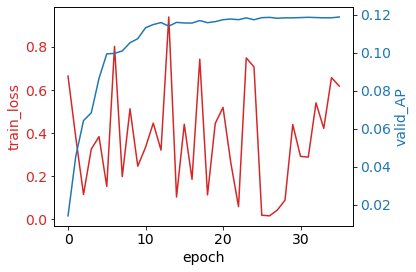

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_AP'])

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('train_loss', color=color)
ax1.plot(history['train_loss'], label='train_loss', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('valid_AP', color=color) 
ax2.plot(history['valid_AP'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

Predict segmentation boxes.

In [0]:
img, _ = dataset_valid[2]

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Visualize the result.

In [0]:
from PIL import Image, ImageDraw

im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
draw = ImageDraw.Draw(im)
for i in range(len(prediction[0]['boxes'])):
  if prediction[0]['labels'][i] == 1:
    color = 'red'
  elif prediction[0]['labels'][i] == 2:
    color = 'blue'
  draw.rectangle(prediction[0]['boxes'][i].cpu().numpy(), outline = color) 
display(im)

In [0]:
import numpy as np
import torch
import torch.utils.data
from PIL import Image, ImageDraw

# img n°7 and 21 are nice
img = Image.open('/tmp/imgs/amsterdam_01071.png').convert("RGB")
with open('/tmp/labels/amsterdam_01071.json') as json_file:
    data = json.load(json_file)

boxes = []
identities = []

for i in range(len(data['children'])):
  identity = data['children'][i]['identity']
  if identity == 'pedestrian' or identity == 'rider':
    box = [data['children'][i]['x0'], data['children'][i]['y0'], \
            data['children'][i]['x1'], data['children'][i]['y1']]
    boxes.append(box)
    if identity == 'pedestrian':
      identities.append(1)
    else:
      identities.append(2)

  for j in range(len(data['children'][i]['children'])):
    identity = data['children'][i]['children'][j]['identity']
    if identity == 'pedestrian' or identity == 'rider':
      box = [data['children'][i]['children'][j]['x0'], data['children'][i]['children'][j]['y0'], \
              data['children'][i]['children'][j]['x1'], data['children'][i]['children'][j]['y1']]
      boxes.append(box)
      if identity == 'pedestrian':
        identities.append(1)
      else:
        identities.append(2)

draw = ImageDraw.Draw(img)
for i in range(len(boxes)):
  if identities[i] == 1:
    color = 'red'
  elif identities[i] == 2:
    color = 'blue'
  draw.rectangle(boxes[i], outline = color) 
display(img)

## BELOW IT'S JUST A TESTING AREA

In [0]:
with open('/tmp/labels/amsterdam_00000.json') as json_file:
    data = json.load(json_file)

boxes = []
identities = []

print('Enfants: ', len(data['children']))
for i in range(len(data['children'])):
  box = [data['children'][i]['x0'], data['children'][i]['y0'], \
         data['children'][i]['x1'], data['children'][i]['y1']]
  identity = data['children'][i]['identity']

  if identity == 'pedestrian':
    identity = 1
  else: 
    identity = 0

  boxes.append(box)
  identities.append(identity)

  for j in range(len(data['children'][i]['children'])):
    print('Petits-enfants: ', len(data['children'][i]['children']))
    box = [data['children'][i]['children'][j]['x0'], data['children'][i]['children'][j]['y0'], \
         data['children'][i]['children'][j]['x1'], data['children'][i]['children'][j]['y1']]
    identity = data['children'][i]['children'][j]['identity']

    if identity == 'pedestrian':
      identity = 1
    else: 
      identity = 0

    boxes.append(box)
    identities.append(identity)

print(boxes)
print(identities)
print(len(boxes))

In [0]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

def get_instance_segmentation_model(num_classes):
  # load a pre-trained model for classification and return only the features
  backbone = torchvision.models.mobilenet_v2(pretrained=True).features
  backbone.out_channels = 1280 # vgg16: 512, mobilenet_v2: 1280
  
  # RPN generate 5 x 3 anchors per spatial location, with 5 different sizes and 
  # 3 different aspect ratios
  anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                    aspect_ratios=((0.5, 1.0, 2.0),))
  
  # feature maps for the region of interest cropping, as well as
  # the size of the crop after rescaling.
  roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                  output_size=7,
                                                  sampling_ratio=2)
  
  model = FasterRCNN(backbone,
                    num_classes,
                    rpn_anchor_generator=anchor_generator,
                    box_roi_pool=roi_pooler)
  return model